In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import copy

In [2]:
# Import functions directly from github
# Important: note that we use raw.githubusercontent.com, not github.com

import requests
url = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/plot_utility.py'
r = requests.get(url)

# Store the file to the colab working directory
with open('plot_utility.py', 'w') as f:
    f.write(r.text)
f.close()

# import the function we want from that file
from plot_utility import plot_tme

# Constants

In [3]:
# System Parameters
m = 0.5 # mass
l = 0.2 # distance from rotor to COM
I = 2/5*m*l**2 # Moment of inertia (Iyy) -- assuming drone is a sphere (it is not)
g = 9.81 # gravity constant

# Control Parameters
tau_k_theta = 10 # torque control to stabilize theta
tau_k_thetadot = 20 # torque control to provide thetadot damping
tau_k_x = 0.01 # torque control to control x position
tau_k_xdot = 0.2 # torque control to provide xdot damping
F_k_z = 1000 # Force control to control z position
F_k_zdot = 10000 # Force control to control z position

F0 = m*g

# Noise for measurements: (standard deviations)
v = [0.01, 0.001, 0.2, 0.2]

# Desired trajectory

In [4]:
def desired_trajectory(t):
    theta_des = 0*np.ones_like(t)
    z_des = 1*np.ones_like(t)
    x_des = np.sin(0.01*t)
    return theta_des, x_des, z_des

# Nonlinear continuous time dynamics with control

In [5]:
def control(X, t):
    theta, thetadot, x, xdot, z, zdot = X
    
    # desired trajectory
    theta_des, x_des, z_des = desired_trajectory(t)
    
    # error
    x_err = x_des - x
    z_err = z_des - z
    
    # control
    tau = -(tau_k_x*x_err - tau_k_xdot*xdot)  + (tau_k_theta*(-theta) - tau_k_thetadot*thetadot)
    F = (F_k_z*z_err - F_k_zdot*zdot)
    
    return F, tau

In [6]:
def f(X, t):
    theta, thetadot, x, xdot, z, zdot = X
    
    # control
    F, tau = control(X, t)
    
    # dynamics
    d_theta = thetadot
    d_thetadot = tau/I
    d_x = xdot
    d_xdot = -F*np.sin(theta)/m
    d_z = zdot
    d_zdot = (F*np.cos(theta)-m*g)/m
    
    d_x = [d_theta, d_thetadot, d_x, d_xdot, d_z, d_zdot]
    
    return d_x

# Run simulation

In [7]:
t = np.arange(0, 1000, 0.1)

x0 = [(np.random.random()-0.5)*1e-3 for i in range(6)]

result = odeint(f, x0, t)
X = result.T

# Plot results

In [8]:
theta = X[0, :]
x = X[2, :]
z = X[4, :]

theta_des, x_des, z_des = desired_trajectory(t)

<Axes: xlabel='Time', ylabel='z'>

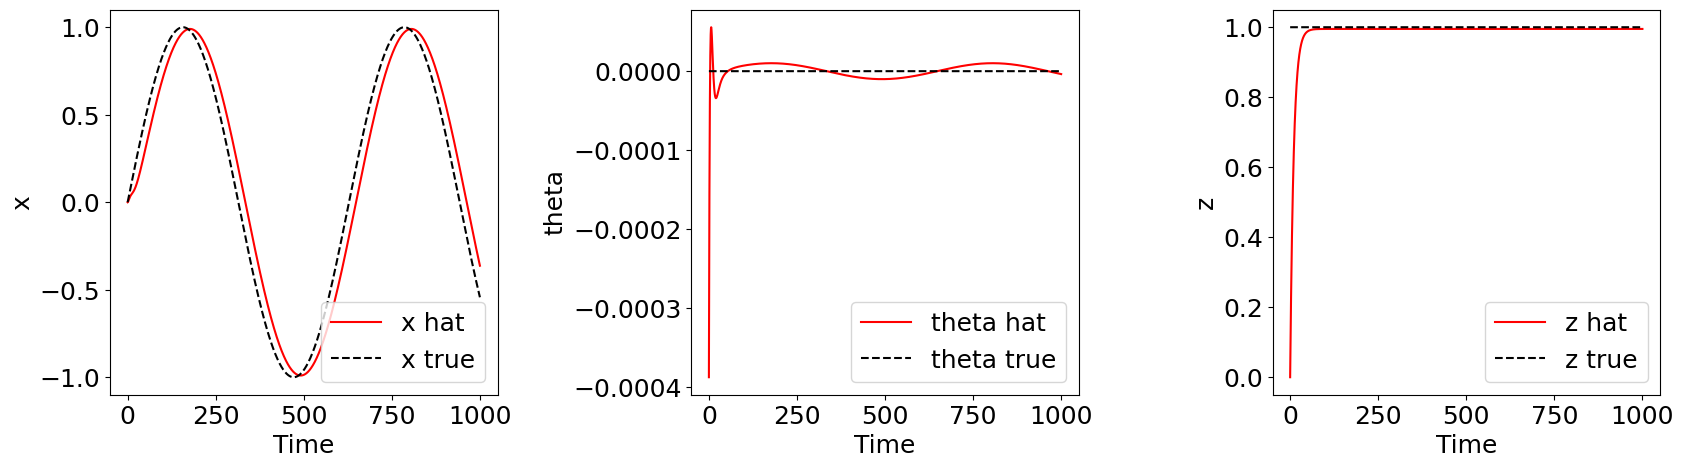

In [9]:
fig = plt.figure(figsize=(20,5))
fig.subplots_adjust(wspace=0.5)


ax1 = fig.add_subplot(131)
plot_tme(t, x_des, None, x, label_var='x', ax=ax1)

ax2 = fig.add_subplot(132)
plot_tme(t, theta_des, None, theta, label_var='theta', ax=ax2)

ax3 = fig.add_subplot(133)
plot_tme(t, z_des, None, z, label_var='z', ax=ax3)

# Measurements

In [10]:
def h(X, v, t):
    theta, thetadot, x, xdot, z, zdot = X
    F, tau = control(X, t)
    
    #xddot_direct = -F*np.sin(theta)/m
    #zddot_direct = (F*np.cos(theta)-m*g)/m
    
    y = np.array([theta, thetadot, x, z]) #, xddot_direct, zddot_direct])
    noise = np.array( [np.random.normal(0, vi) for vi in v] )
    
    return (y + noise).tolist()

In [11]:
Y = np.vstack( [h(X[:,i], v, t[i]) for i in range(X.shape[1]) ] ).T

<Axes: xlabel='Time', ylabel='z'>

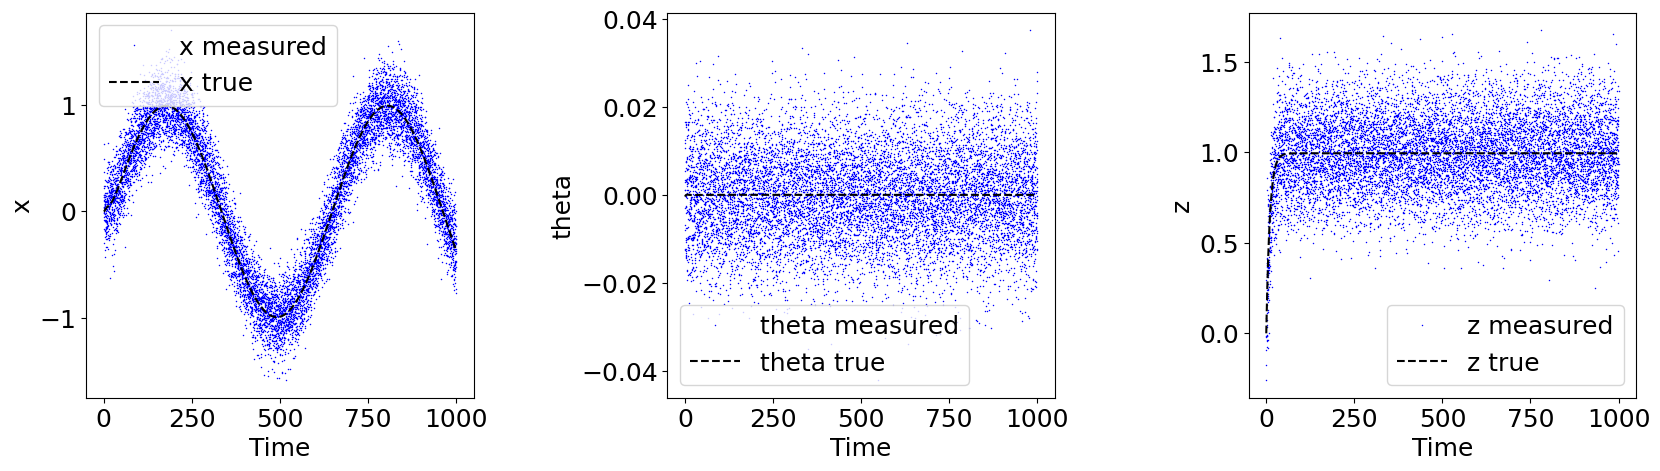

In [12]:
fig = plt.figure(figsize=(20,5))
fig.subplots_adjust(wspace=0.5)


ax1 = fig.add_subplot(131)
plot_tme(t, x, Y[2,:], None, label_var='x', ax=ax1)

ax2 = fig.add_subplot(132)
plot_tme(t, theta, Y[0,:], None, label_var='theta', ax=ax2)

ax3 = fig.add_subplot(133)
plot_tme(t, z, Y[3,:], None, label_var='z', ax=ax3)

# Controls

In [13]:
def control_linear(X, t):
    theta, thetadot, x, xdot, z, zdot = X
    
    # desired trajectory
    theta_des, x_des, z_des = desired_trajectory(t)
    
    # error
    x_err = x_des - x
    z_err = z_des - z
    
    # control
    tau = -(tau_k_x*x_err - tau_k_xdot*xdot)  + (tau_k_theta*(-theta) - tau_k_thetadot*thetadot)
    F = (F_k_z*z_err - F_k_zdot*zdot) - F0
    
    return F, tau

In [14]:
u = control_linear(X, t)
u = np.vstack(u)

# Least Squares Data Driven Model

Assuming ground truth states are available somehow

In [81]:
w = np.array([0.01, 0.001, 0.2, 0.002, 0.2, 0.002])
Xnoisy = copy.copy(X)
for i in range(len(w)):
    Xnoisy[i,:] += np.random.normal(0, w[i], Xnoisy.shape[1])

### preprocess noisy data

In [97]:
import pynumdiff

2024-04-02 11:46:53,655 [INFO] 
Limited Linear Model Support Detected! 
---> PYCHEBFUN is not installed. 
---> Install pychebfun to use chebfun derivatives (https://github.com/pychebfun/pychebfun/) 
You can still use other methods 



In [117]:
Xclean = copy.copy(Xnoisy)
for i in range(Xclean.shape[0]):
    Xclean[i,:], _ = pynumdiff.linear_model.savgoldiff(Xclean[i,:], dt, [2, 50, 50])

### Make model

In [119]:
Xm = Xclean[:,0:-1]
XmU = np.vstack((Xm, u[:,1:]))
Xp = Xclean[:,1:]
AmBm = Xp@np.linalg.pinv(XmU)

In [120]:
Am = AmBm[:,0:6]
Bm = AmBm[:,6:]

In [121]:
C = np.array([[1, 0, 0, 0, 0, 0],
              [0, 1, 0, 0, 0, 0],
              [0, 0, 1, 0, 0, 0],
              [0, 0, 0, 0, 1, 0]])
Cm = C

In [122]:
Ym = Y

In [123]:
if 0:
    dt = np.mean(np.diff(t))

    Am = np.array([[1,        dt, 0, 0,  0, 0],
                  [0,        1,  0, 0,  0, 0],
                  [0,        0,  1, dt, 0, 0],
                  [-F0/m*dt, 0,  0, 1,  0, 0],
                  [0,        0,  0, 0,  1, dt],
                  [0,        0,  0, 0,  0, 1]])

    Bm = np.array([[0,      0],
                  [0,      1/I*dt],
                  [0,      0],
                  [0,      0],
                  [0,      0],
                  [1/m*dt, 0]])

    Cm = np.array([[1, 0, 0, 0, 0, 0],
                  [0, 1, 0, 0, 0, 0],
                  [0, 0, 1, 0, 0, 0],
                  [0, 0, 0, 0, 1, 0]])

    D = np.zeros([4, 2])

# Organize some inputs for the KF

In [144]:
# R is determined by the variance, thus the square of the standard deviation
R = np.diag(v)**2

# Q defines how trustworthy the model is. More trusted models result in smoother estimates. 
# But they can be led astray, and are slower to converge 
#Q = 1e5*np.diag(w)**2
Q = 1e-8*np.eye(6)

# initial state estimate
x0 = [(np.random.random()-0.5)*20 for i in range(6)]
x0 = np.atleast_2d(x0).T

# initial covariance estimate
P0 = 10*np.eye(6)

# Run the KF

In [145]:
#from discrete_linear_kalman import __kalman_forward_filter__

In [146]:
url = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/discrete_linear_kalman.py'
r = requests.get(url)

# Store the file to the colab working directory
with open('discrete_linear_kalman.py', 'w') as f:
    f.write(r.text)
f.close()

from discrete_linear_kalman import __kalman_forward_filter__

In [147]:
xhat_fp, xhat_fm, P_fp, P_fm = __kalman_forward_filter__(x0, P0, Ym, u, Am, Bm, Cm, R, Q)

In [149]:
theta_hat = xhat_fp[0, :]
x_hat = xhat_fp[2, :]
z_hat = xhat_fp[4, :]

In [150]:
end = xhat_fp.shape[1]

(0.0, 2.0)

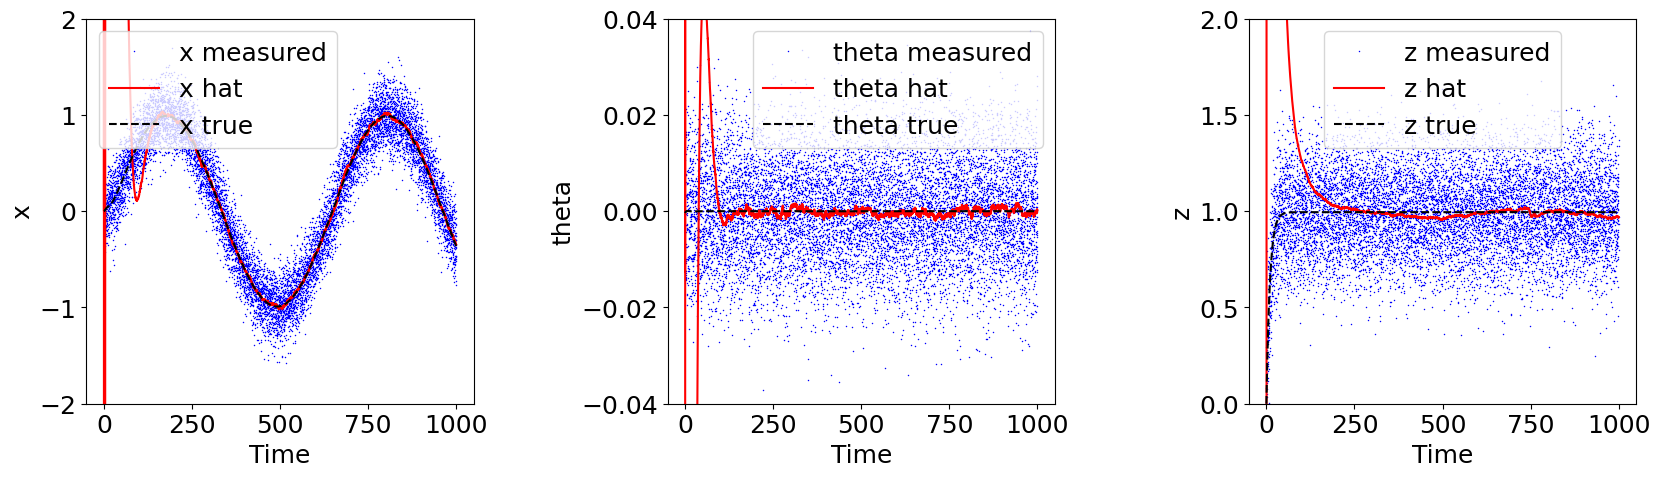

In [151]:
fig = plt.figure(figsize=(20,5))
fig.subplots_adjust(wspace=0.5)


ax1 = fig.add_subplot(131)
plot_tme(t[0:end], x[0:end], Y[2,0:end], x_hat[0:end], label_var='x', ax=ax1)
ax1.set_ylim(-2,2)

ax2 = fig.add_subplot(132)
plot_tme(t[0:end], theta[0:end], Y[0,0:end], theta_hat[0:end], label_var='theta', ax=ax2)
ax2.set_ylim(-0.04,0.04)

ax3 = fig.add_subplot(133)
plot_tme(t[0:end], z[0:end], Y[3,0:end], z_hat[0:end], label_var='z', ax=ax3)
ax3.set_ylim(0, 2)

In [152]:
theta_dot_hat = xhat_fp[1, :]
x_dot_hat = xhat_fp[3, :]
z_dot_hat = xhat_fp[5, :]

theta_dot = X[1, :]
x_dot = X[3, :]
z_dot = X[5, :]

(-0.05, 0.05)

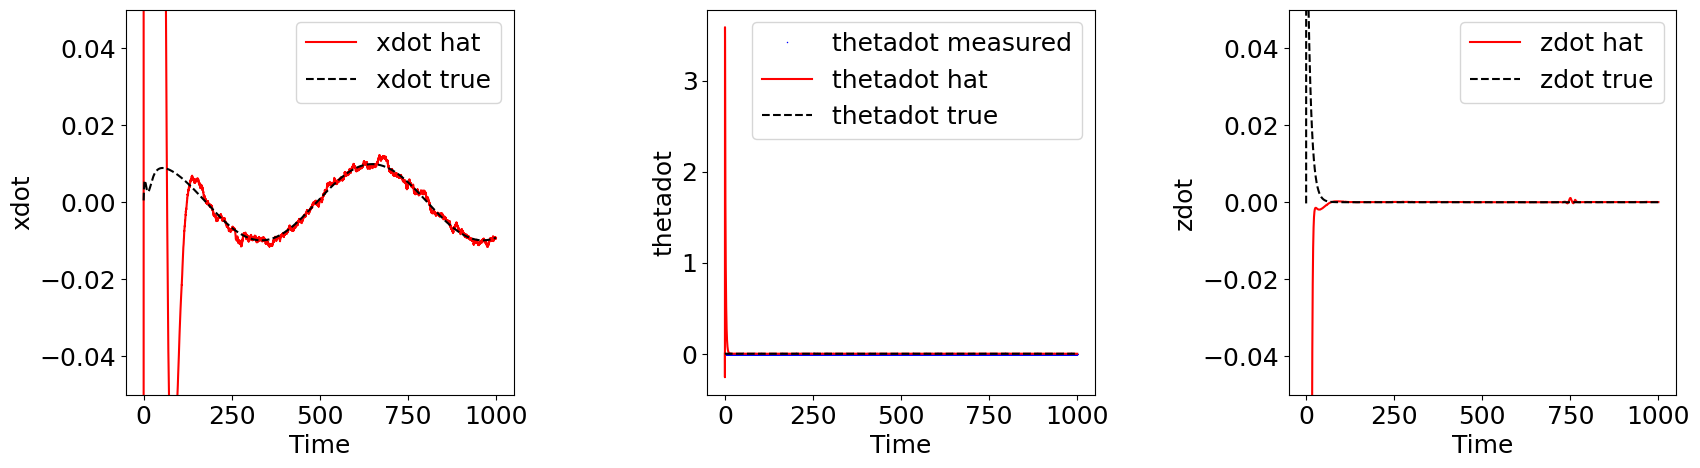

In [153]:
fig = plt.figure(figsize=(20,5))
fig.subplots_adjust(wspace=0.5)


ax1 = fig.add_subplot(131)
plot_tme(t[0:end], x_dot[0:end], None, x_dot_hat[0:end], label_var='xdot', ax=ax1)
ax1.set_ylim(-.05, 0.05)

ax2 = fig.add_subplot(132)
plot_tme(t[0:end], theta_dot[0:end], Y[1,0:end], theta_dot_hat[0:end], label_var='thetadot', ax=ax2)

ax3 = fig.add_subplot(133)
plot_tme(t[0:end], z_dot[0:end], None, z_dot_hat[0:end], label_var='zdot', ax=ax3)
ax3.set_ylim(-.05, 0.05)